# 트랜스포머

## Transformer 모델 구조

Transformer는 Seq2seq와 비슷하게 기계번역을 해결하기 위한 인코더와 디코더구조를 가지고 있습니다. Seq2seq와는 달리 인코더 와 디코더 내부에는 MultiHeadAttention 블록과 FeedForwaed라는 블록으로 구성

<center><img src="https://arxiv.org/html/1706.03762v7/extracted/1706.03762v7/Figures/ModalNet-21.png" width="300"/></center>

출처: `https://arxiv.org/abs/1706.03762`


# 🧩 Transformer 구현 단계별 가이드

---

## ⚙️ 1단계: *Scaled Dot-Product Attention*
트랜스포머의 심장인 **Attention(Q, K, V)** 공식을 코드로 직접 구현합니다.

$$
Attention(Q, K, V) = softmax\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$


- Query(Q), Key(K), Value(V) 벡터 간 유사도 계산  
- Softmax로 중요도를 구하고, Value에 가중합  

---

## 🧠 2단계: *Multi-Head Attention*
1단계에서 만든 어텐션을 여러 개 병렬로 실행하여 “다양한 관점”에서 문장을 바라볼 수 있도록 확장합니다.

- 여러 헤드(`num_heads`)를 통해 병렬 어텐션 수행  
- 각 헤드의 출력을 결합(concat) 후 선형 변환  

---

## 🛡️ 3단계: *Padding & Look-Ahead Masks*
어텐션이 불필요한 `<pad>` 토큰을 무시하고, 디코더가 미래 단어를 **미리 엿보지 못하게** 합니다.

- **Padding Mask** → `<pad>` 위치를 가려 계산 제외  
- **Look-Ahead Mask** → 디코더가 다음 단어를 보지 못하도록 제한  

---

## 🏗️ 4단계: 인코더 유닛 조립 — *EncoderLayer*
**MultiHeadAttention + FeedForwardNetwork + Add & Norm**

- Self-Attention → FFN  
- Residual Connection + LayerNorm  
- 인코더의 기본 레이어 구조 완성  

---

## 🧩 5단계: 디코더 유닛 조립 — *DecoderLayer*
인코더보다 복잡한 구조를 가집니다.

1. Masked Multi-Head Attention (자기 어텐션)  
2. Encoder–Decoder Attention (인코더 출력과의 어텐션)  
3. Feed Forward Network  

각 부분마다 Dropout, Residual, LayerNorm이 적용됩니다.

---

## 🧱 6단계: 최종 모델 조립 — *Encoder, Decoder, Transformer*
4, 5단계에서 만든 층을 N개씩 쌓고, **Positional Encoding**을 추가해 순서 정보를 부여합니다.

- Encoder: 입력 문장 인코딩  
- Decoder: 타깃 문장 생성  
- Transformer: Encoder + Decoder 결합 모델 완성  

---

## 🗂️ 7단계: 데이터 준비 — *Tokenizer & Dataset*
한국어 챗봇 데이터를 불러와 SentencePiece 토크나이저 학습

- SentencePiece로 단어 분절  
- 텍스트를 정수 시퀀스로 변환  
- Padding 적용 → `PyTorch Dataset` 구성  

---

## 🧮 8단계: 모델 학습 — *Training Loop*
Transformer 학습을 위한 학습 루프 구성

- **모델**: Transformer  
- **Optimizer**: Adam  
- **Loss Function**: CrossEntropyLoss(ignore_index=pad_token)  
- **훈련 반복**: forward → loss → backward → optimizer.step()

---

## 🧪 9단계: 추론 및 평가 — *Generation & BLEU*
학습된 모델이 문장을 **스스로 생성(Generate)** 하도록 한 후, 실제 정답과 비교하여 BLEU 점수로 품질을 평가합니다.

- `generate()` 함수로 번역 문장 생성  
- **BLEU Score**: 생성된 문장과 정답 문장의 n-gram 유사도 평가  


### Scaled Dot-Product Attention

먼저 MultiHeadAttention이 구성되기 위해서는 내부적으로 Scaled Dot-Product Attention 연산이 진행이 되어야 함.  

Scaled Dot-Product Attention는 Query와 Key를 **단순 내적**하여 스코어를 계산합니다.

<center><img src="https://arxiv.org/html/1706.03762v7/extracted/1706.03762v7/Figures/ModalNet-19.png" width="200"/></center>

출처: `https://arxiv.org/abs/1706.03762`


$${Attention}(Q, K, V) = \text{softmax}\Bigl(\frac{Q K^\top}{\sqrt{d_k}}\Bigr) \, V$$

- Query와 Key 간의 단순 내적을 활용하므로, 대규모 병렬 연산이 가능하고 시퀀스 전역에 걸쳐 빠르게 Attention 계산을 수행
- 차원이 커지는 문제를 스케일링(√d_k)으로 보정함으로써, 안정적으로 학습이 가능

이때 Transformer는 Scaled Dot-Product Attention의  Qurey, Key, Value를 전부 동일한 텍스트(임베딩)을 넣어 문장 내의 모든 단어(토큰) 간 의존 관계를 동시에 학습하는 **Self-Attention** 기법으로 활용합니다.

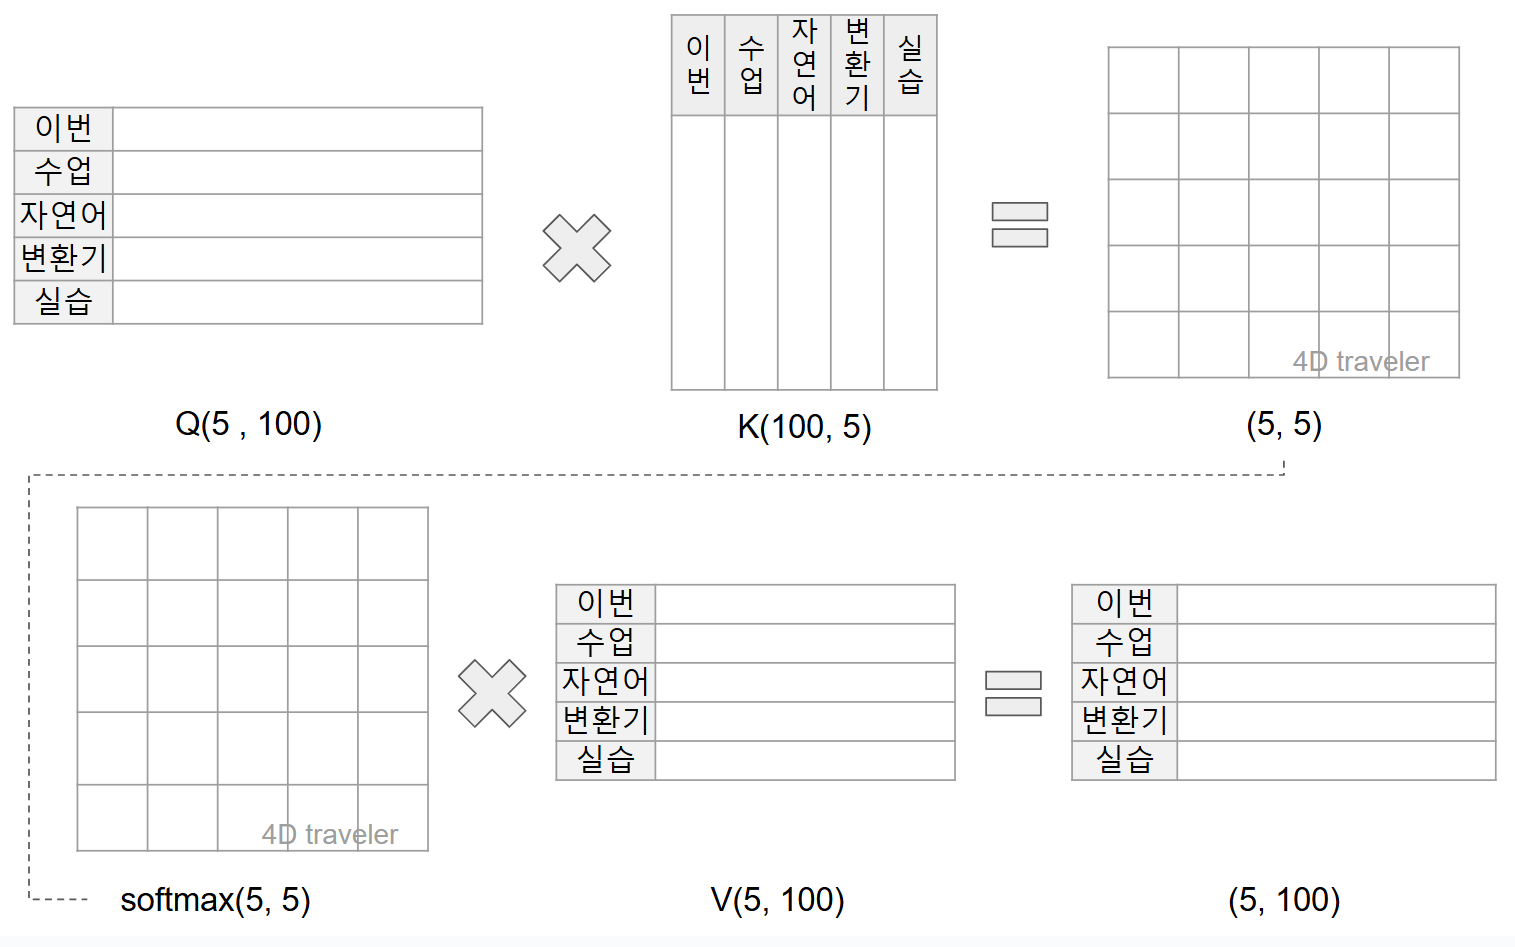


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np

In [7]:
def scaled_dot_product_attention(q, k, v, mask=None):
    """
    Dot Product: Query가 모든 Key와 얼마나 “유사한지(=연관성)”를 나타냄

    멀티헤드 어텐션에서 사용될 경우
    q, k, v : shape = (batch_size, n_heads, seq_len, depth)
    mask    : shape = (batch_size, 1, seq_len, seq_len)
    """
    matmul_qk = torch.matmul(q, k.transpose(-1, -2))        # matrix multiplication 행렬곱셈
    dk = q.size(-1)                                         # dimension of key
    scaled_attention_logits = matmul_qk / math.sqrt(dk)     # scale

    if mask is not None:
        scaled_attention_logits = scaled_attention_logits.masked_fill(mask == False, float('-1e9'))

    attention_weights = F.softmax(scaled_attention_logits, dim=-1)  # softmax

    output = torch.matmul(attention_weights, v)             # output
    return output, attention_weights

# Test
x = torch.randn(3, 20, 64)
out, atw = scaled_dot_product_attention(x, x, x, mask=None)
print(f'attention output shape : {out.shape}')  # (3, 20, 64)
print(f'attention weights shape : {atw.shape}')  # (3, 20, 20)

attention output shape : torch.Size([3, 20, 64])
attention weights shape : torch.Size([3, 20, 20])


### MultiHead Attention

Transformer는 Scaled Dot-Product Attention을 모든 임베딩 차원에서 바로 사용하지 않고 임베딩 차원을 특정 개수로 분할하여 Scaled Dot-Product Attention처리를 합니다.  

MultiHead Attention  임베딩 차원을 여러개의 Head로 분할하여 Scaled Dot-Product Attention처리를 할 뿐만 아니라 각 Q,K,V에 선형레이어를 적용하여 학습 가능한 가중치를 할당해주고 Attention 출력 차원에도 선형레이어로 가중치를 제공합니다.

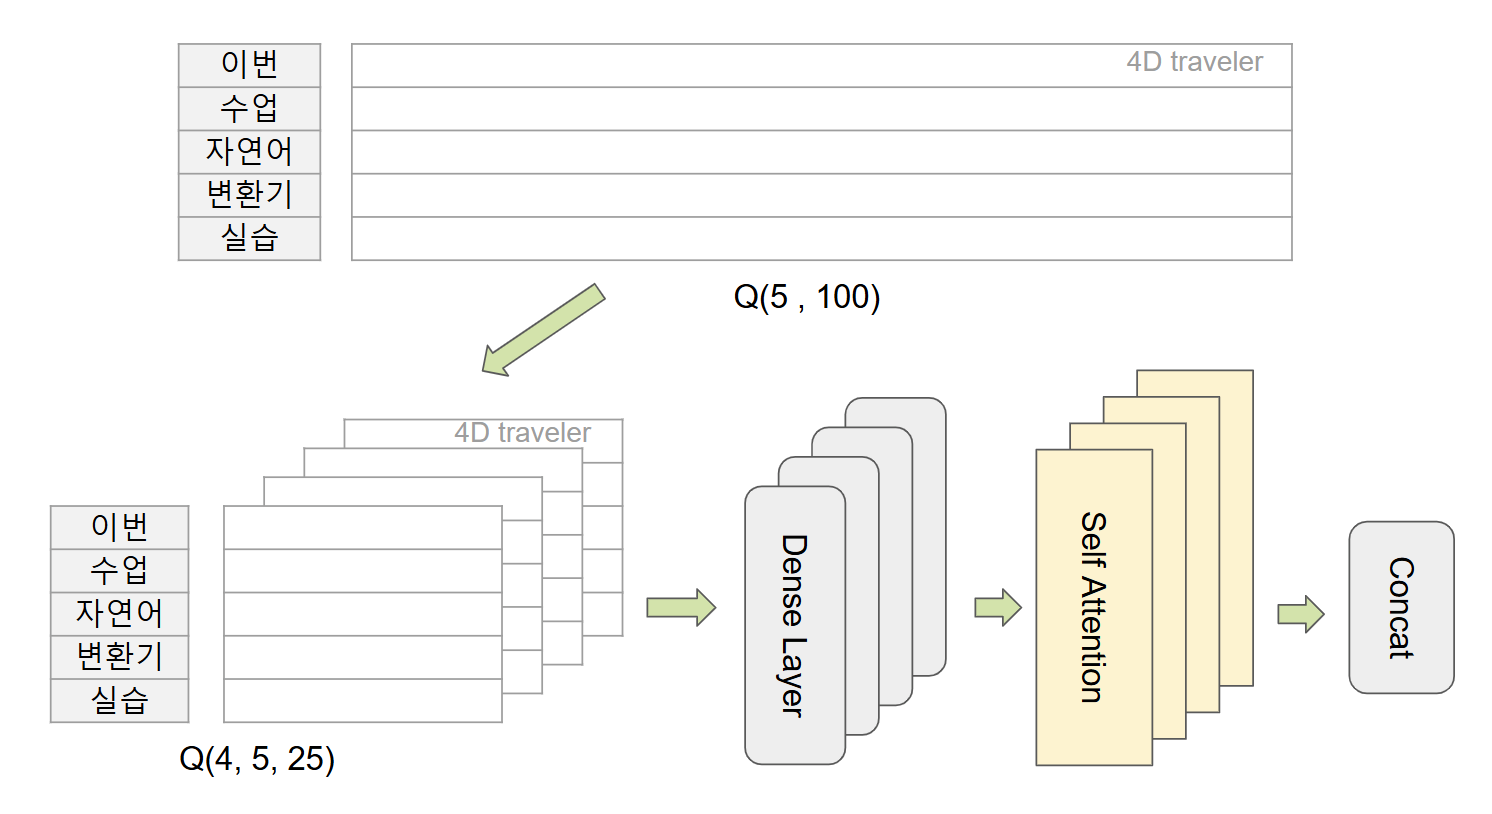

이런 멀테헤드 어텐션을 적용함으로 다음과 같은 특징을 얻습니다.
- Head는 서로 다른 (임베딩)부분 공간에서 Q, K, V를 학습하여 다양한 관점(패턴, 연관성)을 동시에 포착
- 병렬로 Attention을 수행하여 보다 복잡하고 세밀한 관계를 학습
- Head들의 Attention 결과를 결합(Summarize)함으로써 보다 안정적이고 균형 잡힌 정보를 얻음




In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, em_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads              # 헤드 수
        self.em_dim = em_dim                    # 임베딩 차원

        # 임베딩 차원이 헤드 개수로 나누어 떨어져야 함 불가능하면 에러
        assert em_dim % num_heads == 0, "em_dim must be divisible by num_heads"

        # 분리된 임베딩 길이
        self.depth = em_dim // num_heads

        # 선형 레이어 정의
        self.wq = nn.Linear(em_dim, em_dim)
        self.wk = nn.Linear(em_dim, em_dim)
        self.wv = nn.Linear(em_dim, em_dim)

        self.dense = nn.Linear(em_dim, em_dim)

    # Head 분리 함수
    def split_heads(self, x):
        """
            예)
            [------512차원------]
            ↓ 분할 (8개 헤드)
            [64][64][64][64][64][64][64][64]
        """
        batch_size, seq_len, em_dim = x.size()                                      # 예 : (32, 20, 512)(batch_size, seq_len, em_dim)
        x = x.view(batch_size, seq_len, self.num_heads, self.depth)                 # 예 : (32, 20, 512)(batch_size, seq_len, n_heads, depth)
        x = x.permute(0, 2, 1, 3)                                                   # 예 : (32, 20, 8, 64)(batch_size, n_heads, seq_len, depth)
        return x

    def forward(self, v, k, q, mask=None):
        """
        v, k, q: (batch_size, seq_len, em_dim)
        mask   : (batch_size, 1, seq_len, seq_len)
        """
        batch_size = q.size(0)

        # 선형 레이어 통과
        q = self.wq(q)    # (batch_size, seq_len, em_dim)
        k = self.wk(k)    # (batch_size, seq_len, em_dim)
        v = self.wv(v)    # (batch_size, seq_len, em_dim)

        # 헤드 분리
        # 내부 동작: (batch, seq_len, em_dim) → (batch, seq_len, num_heads, depth) → (batch, num_heads, seq_len, depth)
        q = self.split_heads(q)    # (batch_size, n_heads, seq_len, depth)
        k = self.split_heads(k)    # (batch_size, n_heads, seq_len, depth)
        v = self.split_heads(v)    # (batch_size, n_heads, seq_len, depth)

        # 스케일드 닷 프로덕트 어텐션
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        # scaled_attention: (batch_size, n_heads, seq_len, depth)
        # attention_weights: (batch_size, n_heads, seq_len, seq_len)

        # 헤드 결합
        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()  # (batch_size, seq_len, n_heads, depth)
        concat_attention = scaled_attention.view(batch_size, -1, self.em_dim)  # (batch_size, seq_len, em_dim)

        # 최종 선형 레이어
        # 여러 헤드의 결과를 하나로 결합하고, 학습 가능한 선형 변환을 통해 최종 어텐션 출력을 만드는 단계
        output = self.dense(concat_attention)  # (batch_size, seq_len, em_dim)
        return output, attention_weights

# Test
x = torch.randn(2, 10, 64)
mh = MultiHeadAttention(64, 2)
out, atw = mh(x, x, x)
print(f'attention output shape : {out.shape}')
print(f'attention weights shape : {atw.shape}')

attention output shape : torch.Size([2, 10, 64])
attention weights shape : torch.Size([2, 2, 10, 10])


#### MultiHeadAttention 차원 변화

| 단계                             | 연산 / 함수                                       | 텐서 shape                                          | 설명                             |
| ------------------------------ | --------------------------------------------- | ------------------------------------------------- | ------------------------------ |
| ① 입력                           | `x = torch.randn(2, 10, 64)`                  | **(batch=2, seq_len=10, em_dim=64)**              | 2개 문장, 각 문장 길이 10, 임베딩 차원 64   |
| ② 선형 변환                        | `wq(x), wk(x), wv(x)`                         | (2, 10, 64)                                       | 각 토큰을 Query/Key/Value 공간으로 투영  |
| ③ 헤드 분할 (view)                 | `.view(batch, seq_len, num_heads, depth)`     | (2, 10, 2, 32)                                    | 64차원을 2헤드로 분할 (depth = 32)     |
| ④ 축 재배열 (permute)              | `.permute(0, 2, 1, 3)`                        | **(2, 2, 10, 32)**                                | 헤드 차원을 앞으로 이동                  |
| ⑤ Scaled Dot-Product Attention | `scaled_dot_product_attention(q, k, v, mask)` | **출력:** (2, 2, 10, 32)<br>**가중치:** (2, 2, 10, 10) | 헤드별 어텐션 계산 (가중치: Query×Key 관계) |
| ⑥ 축 재배열 (permute back)         | `.permute(0, 2, 1, 3)`                        | (2, 10, 2, 32)                                    | 다시 seq_len 기준으로 정렬             |
| ⑦ 헤드 결합 (view)                 | `.view(batch, seq_len, em_dim)`               | **(2, 10, 64)**                                   | 여러 헤드를 concat하여 원래 임베딩 차원 복원   |
| ⑧ 최종 선형 변환                     | `self.dense(concat_attention)`                | **(2, 10, 64)**                                   | 모든 헤드 결과를 통합해 최종 출력 생성         |


> pytorch에는 멀티헤드어텐션을 구현한 nn.MultiheadAttention 레어가 존재합니다.

### 어텐션 마스크

Transformer는 학습 효율을 위해 크게 두가지의 마스크를 활용하여 연산의 효율을 얻습니다.

- padding mask
    * 토큰 길이(seq_len)에 못 미쳐 패딩이 된 경우 의미 없는 단어가 연산에 적용되지 않게 하기 위한 마스크
    * 인코더와 디코더에서 둘다 사용

- look-ahead mask(미리보기 방지 마스크)   
    * 디코더의 자기회귀(attention) 과정에서 미래 토큰을 참조하지 못하도록 막는 것   
    * 학습 과정에서 디코더가 미래 토큰을 예측하기 위한 학습을 진행 할때 라벨에서 미래 토큰을 마스크 처리하여 지움    
    * 이를 통해 디코더가 반복적인 학습 없이 한번의 병렬 연산으로 처리됨   
    * Causal Mask 용어로 표현하기도 함

In [ ]:
# 패딩된 토큰이 있는 부분은 어탠션 계산에서 무시
def create_padding_mask(seq, pad_token=0):
    '''
    # 예: seq = tensor([[7, 6, 2, 0, 0]])
    # pad_token = 0 → 0인 위치는 패딩임

    # (seq != 0) → tensor([[True, True, True, False, False]])
    # unsqueeze(1) → (batch_size, 1, seq_len)
    # unsqueeze(2) → (batch_size, 1, 1, seq_len)
    # True: 실제 단어, False: 패딩 위치
    # 예시 결과: [[[[1, 1, 1, 0, 0]]]]
    '''
    mask = (seq != pad_token).unsqueeze(1).unsqueeze(2)
    return mask

# 디코더에서 미래 단어를 보지못하게 마스크 생성
def create_look_ahead_mask(size):
    '''
    예: size = 5 → 문장 길이(seq_len)가 5인 경우

    # torch.tril → 하삼각(lower triangle) 부분만 True로 유지
    # [[1,0,0,0,0],
    #  [1,1,0,0,0],
    #  [1,1,1,0,0],
    #  [1,1,1,1,0],
    #  [1,1,1,1,1]]
    '''
    mask = torch.ones(size, size, dtype=torch.bool)
    mask = torch.tril(mask)         # 하삼각 부분만 True. (tril: lower triangular triu: upper triangular)
    return mask                     # (size, size) 아래 삼각형면 True

# Test
inp = torch.tensor([[1, 2, 3, 4, 5, 6, 0, 0, 0, 0], 
                    [3, 5, 6, 2, 6, 5, 8, 0, 0, 0]])

pad_mask = create_padding_mask(inp)
lh_mask = create_look_ahead_mask(10)
print(f'padding mask : \n{pad_mask}')
print(f'look ahead mask : \n{lh_mask}')

padding mask : 
tensor([[[[ True,  True,  True,  True,  True,  True, False, False, False, False]]],


        [[[ True,  True,  True,  True,  True,  True,  True, False, False, False]]]])
look ahead mask : 
tensor([[ True, False, False, False, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False],
        [ True,  True,  True, False, False, False, False, False, False, False],
        [ True,  True,  True,  True, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  T

> nn.MultiheadAttention 사용시 마스크 처리될 부분이 True가 되어야 하므로 반대로 bool을 구현해야 합니다.

In [11]:
x = torch.randn(2, 10, 64)
out, atw = mh(x, x, x, mask=lh_mask)
print(out.shape)
atw[0][0]

torch.Size([2, 10, 64])


tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.2666, 0.7334, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.2951, 0.4069, 0.2980, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3289, 0.1688, 0.2051, 0.2972, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1794, 0.2723, 0.2029, 0.1469, 0.1984, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1577, 0.1592, 0.1004, 0.1843, 0.1720, 0.2264, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1959, 0.1370, 0.1727, 0.1402, 0.1115, 0.1096, 0.1331, 0.0000, 0.0000,
         0.0000],
        [0.0762, 0.1251, 0.1059, 0.1307, 0.0920, 0.1489, 0.1319, 0.1893, 0.0000,
         0.0000],
        [0.0572, 0.1024, 0.0532, 0.1211, 0.1132, 0.2179, 0.1152, 0.0939, 0.1259,
         0.0000],
        [0.0687, 0.0868, 0.0741, 0.0972, 0.0814, 0.1212, 0.1308, 0.1307, 0.0851,
         0.1240]], grad_fn=<

### 인코더 레이어

- Point-wise Feed Forward Network (PFFN)
    * 멀티헤드어텐션 계층만 활용하면 학습할 수 있는 가중치가 너무 작음
    * 선형 레이어와 활성화 함수를 기반으로 각 토큰의 임베딩을 더 풍부하게 변환하여 모델의 표현력을 높이는 역할

- 인코더 레이어
    * 입력 문장에 대한 특성을 학습 하는 레이어로 하나의 멀티헤드어텐션과 PFFN 레이어가 사용
    * 멀티헤드어텐션엔 하나의 문장이 q,k,v로 입력(셀프어텐션)
    * 어텐션 결과는 입력 임베딩과 더하여 LayerNorm를 통과하고 PFFN 레어에 입력
    * 어텐션 결과와 PFFN 결과를 더하여 LayerNorm에 통과하여 최종 출력

> 어텐션 출력를 입력과 더하는 **Skip Connection**(Residual Connection) 과정은 딥러닝에서 층이 깊어질수록 기울기가 소실/폭주하는 문제를 완하하여 학습 안정성을 향상 시킵니다.

In [12]:
# 각 단어 벡터를 독립적으로 비선형 함수(GELU)에 통과시켜, 단어별로 더 풍부한 표현을 학습하게 하는 층
def point_wise_feed_forward_network(em_dim, feed_dim):
    return nn.Sequential(
        nn.Linear(em_dim, feed_dim),            # 입력 임베딩을 더 큰 차원(feed_dim)으로 확장
        nn.GELU(),                              # ReLU보다 부드럽고, BERT/GPT등 최신 트렌스포머에서 표준으로 사용
        nn.Linear(feed_dim, em_dim)             # 다시 원래 임베딩 차원으로 축소
    )

In [14]:
# Transformer 인코더 블록 하나를 구현한 코드
class EncoderLayer(nn.Module):
    """
    한 개의 Encoder Layer는 ① Multi-Head Attention → ② Feed Forward Network 두 블록으로 구성
    각 블록 뒤에는 Residual Connection(잔차 연결) + Layer Normalization 이 있습니다.
    """
    def __init__(self, em_dim, num_heads, feed_dim, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(em_dim, num_heads)
        self.ffn = point_wise_feed_forward_network(em_dim, feed_dim)

        # 두 개의 서브층 : Multi-Head Attention, Feed Forward Network
        self.layernorm1 = nn.LayerNorm(em_dim, eps=1e-6)   # 학습을 안정화 하고, 입력분포를 정규화
        self.layernorm2 = nn.LayerNorm(em_dim, eps=1e-6)
        self.dropout1 = nn.Dropout(rate)            # 과적합 방지, 일부 뉴런을 확률적으로 비활성화
        self.dropout2 = nn.Dropout(rate)

    def forward(self, x, mask=None):
        # Multi_Head Attention 문맥학습
        attn_output, _ = self.mha(x, x, x, mask)          # (batch_size, seq_len, em_dim)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)           # (batch_size, seq_len, em_dim)

        # Feed Forward 단어별 표현을 확장
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)         # (batch_size, seq_len, em_dim)

        return out2

# Test
enc_inp = torch.randn(3, 10, 32)
enc_layer = EncoderLayer(32, 4, 64)
enc_out = enc_layer(x=enc_inp, mask=None)
enc_out.shape

torch.Size([3, 10, 32])

### 디코더 레이어

디코더 레이어는 예측 문장을 만들기 위해 이전 토큰으로 미래 토큰을 학습 하는 레이어로 2개의 멀티헤드어텐션과 하나의 PFFN을 사용합니다.


    * 첫번째 멀티헤드어텐션: 디코더 입력으로 셀프어텐션 진행
    * 첫번째 LayerNorm: 어텐션 결과와 디코더 입력을 더해 LayerNorm 진행
    * 두번째 멀티헤드어텐션: 인코더의 출력이 V,K로 입력되고 첫번째 LayerNorm 출력이 Q로 입력되어 어텐션 진행
    * 두번째 LayerNorm: 첫번째 LayerNorm 출력과 두번째 어텐션 결과를 더해 LayerNorm 진행
    * PFFN: 두번째 LayerNorm 결과를 입력하여 출력 결과를 더해 LayerNorm 진행

In [15]:
# Transformer 디코더 블록(Decoder Block) 하나를 구현한 코드: 인코더 출력을 받아서 다음 단어를 생성할 준비를 하는 핵심 블록
class DecoderLayer(nn.Module):
    '''
    3개의 서브층(sub-layer)
      1) Masked Multi-Head Self-Attention: 디코더 내부 단어들끼리 어텐션 (미래 단어 가리기)
      2) Encoder–Decoder Attention: 인코더의 출력과 어텐션 (입력 문장 참고)
      3) Feed Forward Network (FFN): 각 단어 벡터 독립적으로 비선형 변환
    '''
    def __init__(self, em_dim, num_heads, feed_dim, rate=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(em_dim, num_heads)   # 1) Masked Multi-Head Self-Attention
        self.mha2 = MultiHeadAttention(em_dim, num_heads)   # 2) Encoder–Decoder Attention
        self.ffn = point_wise_feed_forward_network(em_dim, feed_dim)  # 3) Feed Forward Network

        # 세 개의 서브층
        self.layernorm1 = nn.LayerNorm(em_dim, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(em_dim, eps=1e-6)
        self.layernorm3 = nn.LayerNorm(em_dim, eps=1e-6)

        self.dropout1 = nn.Dropout(rate)
        self.dropout2 = nn.Dropout(rate)
        self.dropout3 = nn.Dropout(rate)

    def forward(self, x, enc_output, look_ahead_mask=None, padding_mask=None):
        # Masked Multi-Head Self-Attention: 다음 단어를 예측할 때, 아직 생성되지 않은 미래 단어를 보지 못하게 하면서 문맥(이전 단어들)만 참고하도록 만듧
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)        # look_ahead_mask 미래 단어를 보지 않도록 막는 마스크
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(x + attn1)

        # Encoder–Decoder Attention: 인코더의 출력과 어텐션 (립력문장의 정보와 현재까지 생성된 디코더 문장을 연결)
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # padding_mask 패딩된 토큰을 무시하는 마스크
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(out1 + attn2)
        
        # Feed Forward Network: 각 단어 벡터 독립적으로 비선형 변환
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(out2 + ffn_output)

        return out3, attn_weights_block1, attn_weights_block2

# Test
dec_inp = torch.randn(3, 10, 32)
dec_layer = DecoderLayer(32, 4, 64)
dec_out, w1, w2 = dec_layer(dec_inp, enc_out, None, None)
print(w2.shape)

torch.Size([3, 4, 10, 10])


### 포지션 인코딩
멀티헤드 어텐션은 입력 순서를 고려하지 않는(Self-Attention) 구조이므로, 단어의 순서 정보 추가 필요합니다.
이러한 순서정보를 추가하기 위해 토큰 임베딩 결과에 순서정보를 더해줍니다.

포지션 인코딩은 각 포지션의 각도를 구한뒤 sin, cos 함수를 적용하여 상대적인 위치 정보 만들어 냅니다. 이는 병렬처리를 진행하는 트랜스포머에 매우 효율적인 순서 정보를 제공할 수 있습니다.

\begin{aligned}
\text{PE}(pos,\,2i) &= \sin\!\Bigl(\tfrac{pos}{10000^{\,\frac{2i}{d_{\text{model}}}}}\Bigr),\\[8pt]
\text{PE}(pos,\,2i+1) &= \cos\!\Bigl(\tfrac{pos}{10000^{\,\frac{2i}{d_{\text{model}}}}}\Bigr).
\end{aligned}

- 각 토큰의 위치(pos) 에 대해, 특정 각도(주파수)로 변환한 뒤, sin(짝수)과 cos(홀수) 함수를 적용하여 임베딩 차원별로 다른 주기를 갖는 사인파 생성
- 서로 다른 위치(pos) 간의 상대적 거리를 함수의 위상 차이를 통해 모델이 학습


In [16]:
# Transformer의 “Positional Encoding” 을 시각화
# 문장 내 단어 위치(position)에 따라 사인(sin)과 코사인(cos) 주기로 변하는 값을 만들어, 단어의 위치정보를 벡터로 표현하고 시각화
import matplotlib.pyplot as plt

# 위치에 따른 각도 추출
def get_angles(pos, i, em_dim):
    # 하나의 위치에서 임베딩의 길이 만큼 각도가 추출됨
    return pos / (10000 ** ((2 * (i // 2)) / em_dim))

# 각도로 부터 사인파 생성
def positional_encoding(position, em_dim):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(em_dim)[np.newaxis, :],
        em_dim
    )

    # 짝수 인덱스에는 사인 함수 적용, 홀수 인덱스에는 코사인 함수 적용
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])  # 짝수 인덱스
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])  # 홀수 인덱스

    pos_encoding = angle_rads[np.newaxis, ...]  # (1, position, em_dim)
    return torch.tensor(pos_encoding, dtype=torch.float32)

position = 50    # 문장 내 단어 위치 수
em_dim = 16    # 임베딩 차원

pos_encoding = positional_encoding(position, em_dim)
print(pos_encoding.shape)  # (1, position, em_dim)

torch.Size([1, 50, 16])


### 최종 인코더와 디코더

지금까지 구현한 인코더 레이어와 디코더 레이어, 임베딩 레이어, 포지션 인코딩을 결합하여 Transformer 아키텍쳐를 만듭니다.

<center><img src="https://arxiv.org/html/1706.03762v7/extracted/1706.03762v7/Figures/ModalNet-21.png" width="300"/></center>

In [20]:
class Encoder(nn.Module):
    """
    1) Embedding: 단어 ID → 임베딩 벡터로 변환 후 스케일링
    2) Positional Encoding: 위치 정보(sin/cos)를 임베딩에 더함
    3) Dropout: 입력 임베딩+포지션에 드롭아웃 적용
    4) Stacked EncoderLayers (각 층마다):
      - Multi-Head Self-Attention
      - Dropout + Residual + LayerNorm
      - Feed Forward Network (FFN)
      - Dropout + Residual + LayerNorm
    """
    def __init__(self, num_layers, em_dim, num_heads, feed_dim, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.em_dim = em_dim
        self.num_layers = num_layers

        # 1) Embedding
        self.embedding = nn.Embedding(input_vocab_size, em_dim)
        # 2) Positional Encoding
        self.pos_encoding = positional_encoding(maximum_position_encoding, em_dim)

        # 3) encoder layers 쌓기
        self.enc_layers = nn.ModuleList([
            EncoderLayer(em_dim, num_heads, feed_dim, rate)
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(rate)

    def forward(self, x, mask=None):
        seq_len = x.size(1)

        # 임베딩 후 스케일링
        x = self.embedding(x)
        x = x * math.sqrt(self.em_dim)

        # 포지셔널 인코딩
        pe = self.pos_encoding[:, :seq_len, :].to(x.device)

        # 임베팅과 포지션 결합
        x = x + pe
        x = self.dropout(x)

        # 인코더 레이어층 통과
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)

        return x  # (batch_size, seq_len, em_dim)

In [21]:
class Decoder(nn.Module):
    """
    1) Embedding + 스케일링: 디코더 입력 토큰을 벡터로 변환하고 크기를 보정
    2) Positional Encoding: 위치 정보를 sin/cos 패턴으로 임베딩에 더함
    3) Dropout: 임베딩+포지션에 드롭아웃 적용 (과적합 방지)
    4) Stacked DecoderLayers (각 층마다)
      - Masked Multi-Head Self-Attention: 미래 토큰을 가린 자기 어텐션
      - Encoder–Decoder Attention: 인코더 출력과의 관계 학습
      - Feed Forward Network (FFN): 각 단어 벡터 비선형 변환
      - 각 블록마다 Dropout + Residual + LayerNorm으로 안정화
      - Attention Weights 저장: block1(자기), block2(인코더-디코더) 기록
    """
    def __init__(self, num_layers, em_dim, num_heads, feed_dim, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.em_dim = em_dim
        self.num_layers = num_layers

        # 1) Embedding
        self.embedding = nn.Embedding(target_vocab_size, em_dim)
        # 2) Positional Encoding
        self.pos_encoding = positional_encoding(maximum_position_encoding, em_dim)

        # 3) decoder layers 쌓기
        self.dec_layers = nn.ModuleList([
            DecoderLayer(em_dim, num_heads, feed_dim, rate)
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(rate)

    def forward(self, x, enc_output, look_ahead_mask=None, padding_mask=None):
        seq_len = x.size(1)
        attention_weights = {}

        # 임베딩 후 스케일링
        x = self.embedding(x)  # (batch_size, target_seq_len, em_dim)
        x = x * math.sqrt(self.em_dim)

        # 포지셔널 인코딩
        pe = self.pos_encoding[:, :seq_len, :].to(x.device)

        # 임베팅과 포지션 결합
        x = x + pe
        x = self.dropout(x)

        # 디코더 레이어층 통과
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)

            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        return x, attention_weights  # (batch_size, target_seq_len, em_dim)

In [22]:
eco_inp = torch.Tensor([[1, 2, 3, 4, 5, 6, 0, 0, 0, 0]]).long()
dec_inp = torch.Tensor([[1, 2, 3, 4, 5, 6, 7, 8, 0, 0]]).long()
pad_mask = create_padding_mask(eco_inp)
lh_mask = create_look_ahead_mask(10)

ecoder = Encoder(2, 32, 4, 64, 10, 100)
eco_out = ecoder(eco_inp, pad_mask)
print(f'ecoder out: {eco_out.shape}')
decoder = Decoder(2, 32, 4, 64, 10, 100)
dec_out, attn = decoder(dec_inp, eco_out, lh_mask, pad_mask)
print(f'decoder out: {dec_out.shape}')

ecoder out: torch.Size([1, 10, 32])
decoder out: torch.Size([1, 10, 32])


In [23]:
# 디코더 2번째 블럭의 0번 배치 어텐션 가중치
print('1번 어텐션')
print(attn['decoder_layer2_block1'][0])
print('2번 어텐션')
print(attn['decoder_layer2_block2'][0])

1번 어텐션
tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.6084, 0.3916, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.2660, 0.5390, 0.1950, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.2119, 0.2595, 0.1728, 0.3558, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.1412, 0.3834, 0.1394, 0.1856, 0.1505, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.1818, 0.0512, 0.2609, 0.2301, 0.1863, 0.0897, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.1570, 0.2249, 0.0963, 0.1091, 0.1410, 0.1468, 0.1249, 0.0000,
          0.0000, 0.0000],
         [0.0794, 0.2010, 0.0757, 0.1433, 0.0640, 0.1906, 0.1079, 0.1382,
          0.0000, 0.0000],
         [0.0471, 0.2027, 0.0436, 0.1120, 0.0400, 0.1891, 0.1082, 0.1546,
          0.1028, 0.0000],
         [0.0732, 0.1294, 0.0615, 0.1005, 0.0665, 0.1318, 0.0956, 0.1090,
          

### Transformer 모델링

인코더와 디코더를 결합하고 최종 분류기를 더한 Transformer 구조를 만듭니다. 이때 인코더와 디코더에 넣어줄 마스크를 `forward` 단계에서 생성합니다.

완성된 Transformer모델의 `forward`는 학습을 위한 순전파로 타겟이 같이 입력 되어야 합니다. 따라서 학습된 Transformer모델로 텍스트를 생성하는 작업은 `forward` 함수를 활용하기에 적절 하지 않습니다.
해당 예시에선느 학습된 Transformer를 활용해 텍스트를 생성하기 위한 `generate` 함수를 따로 구현 합니다.

**generate 함수**
- 인코더 입력될 토큰셋과 디코더에 입력될 시작 토큰 하나만 입력으로 받아 자기회귀(Autoregressive)방식으로 토큰을 생성
- 최대 토큰 길이를 설정하여 디코더의 토큰 예측을 반복하고 문장 끝 토큰이 나오는 경우 반복을 중단
- 토큰 id를 실제 단어 토큰으로 변환하여 출력



In [26]:
class Transformer(nn.Module):
    def __init__(self, num_layers, em_dim, num_heads, feed_dim, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, em_dim, num_heads, feed_dim, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, em_dim, num_heads, feed_dim, target_vocab_size, pe_target, rate)

        self.final_layer = nn.Linear(em_dim, target_vocab_size)

    def create_masks(self, inp, tar, pad_token=0):
        # 인코더 패딩 마스크
        enc_padding_mask = create_padding_mask(inp, pad_token)

        # 디코더 패딩 마스크
        dec_padding_mask = create_padding_mask(inp, pad_token)

        # 디코더 룩 어헤드 마스크 + 패딩 마스크
        seq_len = tar.size(1)
        look_ahead = create_look_ahead_mask(seq_len).to(tar.device)
        look_ahead = look_ahead.unsqueeze(0).unsqueeze(0)  # (1, 1, seq_len, seq_len)

        # 타겟(디코더 입력)에도 패딩이 있을 수 있으니
        dec_target_padding_mask = create_padding_mask(tar, pad_token)
        combined_mask = look_ahead & dec_target_padding_mask  # 둘다 True 일때 True

        return enc_padding_mask, combined_mask, dec_padding_mask

    def forward(self, inp, tar, pad_token=0):
        enc_padding_mask, combined_mask, dec_padding_mask = self.create_masks(inp, tar, pad_token)

        enc_output = self.encoder(inp, enc_padding_mask)  # (batch_size, inp_seq_len, em_dim)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, look_ahead_mask=combined_mask, padding_mask=dec_padding_mask
        )
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        
        return final_output, attention_weights

    # 텍스트 생성함수 (Auto-Regressive)
    @torch.no_grad()
    def generate(self, enc_input, start_tokens, end_token=None, pad_token=0, max_new_tokens=50, device='cpu'):
        '''
        enc_input: 인코더 입력 문장 (배치 크기 1)
        start_tokens: 디코더 시작 토큰 ID (배치 크기 1)
        end_token: 디코더 종료 토큰 ID
        pad_token: 패딩 토큰 ID
        max_new_tokens: 생성할 최대 토큰 수
        device: 연산 장치 (CPU/GPU)
        '''
        # ===== 추가
        enc_input = enc_input.to(device)
        # ===== 추가

        enc_padding_mask = create_padding_mask(enc_input, pad_token)
        enc_output = self.encoder(enc_input, enc_padding_mask.to(device))

        # 동적으로 입력 토클을 만들어 냄
        generated_tokens = [start_tokens]

        for _ in range(max_new_tokens):
            # 현재까지 생성된 토큰
            cur_tokens = torch.tensor(generated_tokens, dtype=torch.long, device=device)
            cur_tokens = cur_tokens.unsqueeze(0)  # 배치 차원 추가 (1, cur_seq_len)

            # 디코더 마스크 생성
            enc_padding_mask, combined_mask, dec_padding_mask = self.create_masks(enc_input, cur_tokens, pad_token)

            with torch.no_grad():
                dec_output, _ = self.decoder(
                    cur_tokens, enc_output, look_ahead_mask=combined_mask, padding_mask=dec_padding_mask
                )
                # 마지막 토큰 위치의 출력만 추출
                logits = self.final_layer(dec_output)  # (1, cur_seq_len, target_vocab_size)
                next_token_logits = logits[:, -1, :]  # (1, target_vocab_size

                # 그리디: 가장 확률이 높은 토큰 선택
                next_token = next_token_logits.argmax(dim=-1).item()
            
            generated_tokens.append(next_token)

            # 종료 토큰이 나오면 중단
            if end_token is not None and next_token == end_token:
                break
        
        return generated_tokens

In [29]:
# --- 트랜스포머 모델 하이퍼파라미터 설정 ---
# 인코더 입력 예시 (배치 1, 시퀀스 10) / <pad> 토큰 0 가정
eco_inp = torch.Tensor([[1, 2, 3, 4, 5, 6, 0, 0, 0, 0]]).long()

# 디코더 입력 예시 (배치 1, 시퀀스 10) / <pad> 토큰 0 가정
dco_inp = torch.Tensor([[1, 2, 3, 4, 5, 6, 7, 8, 0, 0]]).long()

num_layers = 2          # 인코더/디코더 블록(레이어)의 개수
em_dim = 32             # 임베딩 벡터의 차원
num_heads = 4           # 멀티-헤드 어텐션의 헤드 개수
feed_dim = 64           # FFN 내부 은닉층의 차원
input_vocab_size = 16   # 입력(소스) 단어 집합(Vocabulary) 크기
target_vocab_size = 16  # 타겟(대상) 단어 집합(Vocabulary) 크기
pe_input = 100          # 인코더의 최대 포지션(시퀀스 길이)
pe_target = 100         # 디코더의 최대 포지션(시퀀스 길이)

transformer = Transformer(num_layers, em_dim, num_heads, feed_dim, input_vocab_size, target_vocab_size, pe_input, pe_target)
out, atw = transformer(eco_inp, dco_inp)
generated_token = transformer.generate(eco_inp, 2, 3, 0)
print(f'최종 출력 형상 {out.shape}')
print(f'토큰 생성 결과 {generated_token}')

최종 출력 형상 torch.Size([1, 10, 16])
토큰 생성 결과 [2, 6, 11, 6, 11, 6, 9, 13, 7, 8, 0, 11, 6, 11, 6, 11, 6, 11, 6, 3]


## Transformer 학습 하기
### 데이터세트 준비

이전 Seq2seq 모델 학습과 동일하게 준비한 Transformer 모델에 [AIHUB](https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&dataSetSn=86) 한국어 감성 대화 말뭉치를 부분적으로 활용하여 질의(입력) 응답(타겟) 데이터세트를 학습 합니다.

In [33]:
with open("/mnt/nas/jayden_code/Codeit_Practice/Part3_01_자연어처리_실습/train.csv", "r", encoding="utf-8") as f:
    text = f.read()


In [35]:
from torch.utils.data import Dataset, DataLoader, random_split
import sentencepiece as spm
import pandas as pd

df = pd.read_csv(f'/mnt/nas/jayden_code/Codeit_Practice/Part3_01_자연어처리_실습/train.csv')
df

,label,HS01,SS01,HS02,SS02,HS03,SS03
0,E1,일은 왜 해도 해도 끝이 없을까? 화가 난다.,많이 힘드시겠어요. 주위에 의논할 상대가 있나요?,그냥 내가 해결하는 게 나아. 남들한테 부담 주고 싶지도 않고.,혼자 해결하기로 했군요. 혼자서 해결하기 힘들면 주위에 의논할 사람을 찾아보세요.,NaN,NaN
1,E1,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.,급여가 줄어 속상하시겠어요. 월급이 줄어든 것을 어떻게 보완하실 건가요?,최대한 지출을 억제해야겠어. 월급이 줄어들었으니 고정지출을 줄일 수밖에 없을 것 같아.,월급이 줄어든 만큼 소비를 줄일 계획이군요.,NaN,NaN
2,E1,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,회사 동료 때문에 스트레스를 많이 받는 것 같아요. 문제 해결을 위해 어떤 노력을 ...,잘 안 맞는 사람이랑 억지로 잘 지내는 것보단 조금은 거리를 두고 예의를 갖춰서 대...,스트레스받지 않기 위해선 인간관계에 있어 약간의 거리를 두는 게 좋겠군요.,NaN,NaN
3,E1,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,관련 없는 심부름을 모두 하게 되어서 노여우시군요. 어떤 것이 상황을 나아질 수 있...,직장 사람들과 솔직하게 이야기해보고 싶어. 일하는 데에 방해된다고.,직장 사람들과 이야기를 해 보겠다고 결심하셨군요.,NaN,NaN
4,E1,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.,무시하는 것 같은 태도에 화가 나셨군요. 상대방의 어떤 행동이 그런 감정을 유발하는...,상사인 나에게 먼저 인사하지 않아서 매일 내가 먼저 인사한다고!,항상 먼저 인사하게 되어 화가 나셨군요. 어떻게 하면 신입사원에게 화났음을 표현할 ...,NaN,NaN
...,...,...,...,...,...,...,...
51623,E1,나이가 먹고 이제 돈도 못 벌어 오니까 어떻게 살아가야 할지 막막해. 능력도 없고.,경제적인 문제 때문에 막막하시군요. 마음이 편치 않으시겠어요.,아무것도 할 수 없는 내가 무가치하게 느껴지고 실망스러워.,지금 할 수 있는 가장 합리적인 행동은 무엇인가요?,노년층을 위한 경제적 지원이나 부업 같은 것도 알아보아야겠어.,좋은 결과 얻으시길 바랄게요.
51624,E3,몸이 많이 약해졌나 봐. 이제 전과 같이 일하지 못할 것 같아 너무 짜증 나.,건강에 대한 어려움 때문에 기분이 좋지 않으시군요. 속상하시겠어요.,마음 같아서는 다 할 수 있는 일인데 이젠 몸이 안 따라와 주니 화만 나.,어떻게 하면 지금의 기분을 나아지게 할 수 있을까요?,남편과 함께 게이트볼이나 치러 가야겠어. 그럼 기분이 나아질 것 같아.,남편과 함께하는 좋은 외출 시간 되시길 바랄게요.
51625,E4,이제 어떻게 해야 할지 모르겠어. 남편도 그렇고 노후 준비도 안 되어서 미래가 걱정돼.,노후 준비에 대한 어려움 때문에 걱정이 많으시겠어요.,주변 사람들은 다 노후 준비도 잘해두었던데 난 어떻게 해야 할지 모르겠어. 막막하기...,지금의 상황에서 할 수 있는 가장 좋은 행동이 무엇일까요?,남편과 함께 실버 일자리나 노년층을 위한 국가 지원에 대해 자세히 알아보아야겠어.,좋은 정보 많이 얻으셔서 걱정을 좀 덜으셨으면 좋겠어요.
51626,E3,몇십 년을 함께 살았던 남편과 이혼했어. 그동안의 세월에 배신감을 느끼고 너무 화가 나.,가족과의 문제 때문에 속상하시겠어요.,이제 할 수 있는 일도 없고 이렇게 힘들게 사는 게 불만스럽기만 해.,지금의 감정을 나아지게 할 수 있는 어떤 방법이 있을까요?,함께 친하게 지내던 동네 언니 동생들과 빈자리를 조금이나마 채울까 해.,지인분들과 좋은 시간 보내셨으면 좋겠어요.


In [36]:
import sentencepiece as spm
import re
import os

# 추가 쓰기모드로 텍스트 파일 열기
with open('train.txt', 'a', encoding='utf-8') as f:
  for text in df['HS01'] :
        text = str(text)
        try:
            f.write(text+'\n')
        except:
                pass


# 저장 경로 생성
os.makedirs('./model', exist_ok=True)

spm.SentencePieceTrainer.train(
    input='train.txt',                    # 텍스트 뭉치 파일
    model_prefix='./model/spm_krsent',    # 출력 모델 파일 이름
    vocab_size=2000                       # 토큰 개수
)


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: train.txt
  input_format: 
  model_prefix: ./model/spm_krsent
  model_type: UNIGRAM
  vocab_size: 2000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0


In [38]:
class SPDataSet(Dataset):
    def __init__(self, sp, max_len):
        self.max_len = max_len
        self.df = pd.read_csv(f'/mnt/nas/jayden_code/Codeit_Practice/Part3_01_자연어처리_실습/train.csv')[['HS01','SS01']]
        self.sp = sp

    def zero_pad(self, tok):
        if len(tok) >= self.max_len:
            return tok[:self.max_len]
        else:
            padding = np.zeros(self.max_len)
            padding[:len(tok)] = tok
            return padding

    def __len__(self):
        return (len(self.df))

    def __getitem__(self, i):
        sent = self.df.iloc[i]
        sent1 = self.sp.encode_as_ids(sent['HS01'])
        sent2 = self.sp.encode_as_ids(sent['SS01'])

        inp = self.zero_pad(sent1 + [self.sp.eos_id()])
        tar = self.zero_pad([self.sp.bos_id()] + sent2 + [self.sp.eos_id()])

        return torch.Tensor(inp), torch.Tensor(tar)


sp = spm.SentencePieceProcessor(model_file=f'./model/spm_krsent.model')
dataset = SPDataSet(sp, 60)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

for inp, tar in dataloader:
    print(inp.long())
    print(tar.long()[:,:-1])
    print(tar.long()[:,1:])
    break

tensor([[ 606,  356,  551,   92,  530,    5,  106,  203,  222,  184,  136,   52,
           70,   23,    4,  955,  143,  703,   55,   73,  530,  120,  478,  253,
          396,  178,    3, 1050,   57,  663,    4,    2,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])
tensor([[  1, 989,  55, 351,   8,  39,  45, 603, 148, 358,  24,  16,  90,  15,
         642, 377,   4,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0]])
tensor([[989,  55, 351,   8,  39,  45, 603, 148, 358,  24,  16,  90,  15, 642,
         377,   4,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0, 

In [40]:
# batch_size, seq_len => batch_size * seq_len 하여 손실 연산
def loss_function(real, pred, pad_token=0):
    loss_fn = nn.CrossEntropyLoss(ignore_index=pad_token)
    pred_reshaped = pred.view(-1, pred.size(-1))
    real_reshaped = real.reshape(-1)

    return loss_fn(pred_reshaped, real_reshaped)

# 하이퍼파라미터 설정
sp = spm.SentencePieceProcessor(model_file=f'./model/spm_krsent.model')
num_layers = 4
d_model = 128                       # emd_dim
dff = 256                           # feed_dim
num_heads = 4
vocab_size = sp.get_piece_size()
pe_input = 10000
pe_target = 10000
dropout_rate = 0.1
max_len = 60
pad_token = 0
lr = 2e-4
batch_size = 64
epochs = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델생성
transformer = Transformer(num_layers, d_model, num_heads, dff, vocab_size, vocab_size, pe_input, pe_target, dropout_rate).to(device)
optimizer = torch.optim.Adam(transformer.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)

# 간략한 실험을 위해 평가데이터 분리 생략
daraset = SPDataSet(sp, max_len)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for e in range(epochs):
    transformer.train()
    total_loss = 0.0
    for i, (inp, tar) in enumerate(dataloader):
        inp = inp.long().to(device)
        tar = tar.long().to(device)

        tar_in = tar[:, :-1]
        tar_out = tar[:, 1:]

        optimizer.zero_grad()
        pred, _ = transformer(inp, tar_in, pad_token=pad_token)

        loss = loss_function(tar_out, pred, pad_token=pad_token)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        if (i + 1) % 200 == 0:
            print(f'Epoch: {e}, Batch {i+1}, Loss: {total_loss / (i+1)}')
    print(f"====>Epoch: {e}, Loss: {total_loss/(i+1)}")
        

Epoch: 0, Batch 200, Loss: 5.196405658721924
Epoch: 0, Batch 400, Loss: 4.611199192404747
Epoch: 0, Batch 600, Loss: 4.305037969350815
Epoch: 0, Batch 800, Loss: 4.0989827200770375
====>Epoch: 0, Loss: 4.092678834366828
Epoch: 1, Batch 200, Loss: 3.2923032796382903
Epoch: 1, Batch 400, Loss: 3.2498887258768083
Epoch: 1, Batch 600, Loss: 3.2037360922495526
Epoch: 1, Batch 800, Loss: 3.1622249925136567
====>Epoch: 1, Loss: 3.1615778200392977
Epoch: 2, Batch 200, Loss: 2.9560944700241087
Epoch: 2, Batch 400, Loss: 2.939800903201103
Epoch: 2, Batch 600, Loss: 2.9133786233266195
Epoch: 2, Batch 800, Loss: 2.8901854768395423
====>Epoch: 2, Loss: 2.8891985821162605
Epoch: 3, Batch 200, Loss: 2.7689848017692564
Epoch: 3, Batch 400, Loss: 2.7520469522476194
Epoch: 3, Batch 600, Loss: 2.7389363416035972
Epoch: 3, Batch 800, Loss: 2.7174887377023698
====>Epoch: 3, Loss: 2.7169716618170376
Epoch: 4, Batch 200, Loss: 2.6170208072662353
Epoch: 4, Batch 400, Loss: 2.609913162589073
Epoch: 4, Batch 60

> Seq2seq 모델에 비해 더욱 빠른 속도로 손실이 줄어드는것을 확인할 수 있습니다. 충분한 학습이 이루어지면 적절한 텍스트를 생성할 수 있습니다.

### 생성 텍스트 평가하기

- BLEU(Bilingual Evaluation Understudy)
    * n-gram 기반으로 참조 문장과 생성 문장 간 **정밀도(Precision)**를 측정하며, 짧은 문장 페널티(Brevity Penalty) 등을 통해 실제 번역 품질을 반영하도록 고안된 지표
    * 주로 기계 번역에서 모델이 원문을 얼마나 정확히 번역했는지 평가할 때 사용


#### BLEU 평가

- 각 n-gram별로 **(생성 문장에 등장하는 n-gram 중 참조와 일치하는 횟수) / (생성 문장 전체 n-gram 수)**를 구해 정밀도를 계산

- 1,2,3,4-gram 정밀도를 기하평균으로 합산하고, Brevity Penalty를 곱해 최종 BLEU 스코어가 완성

- 생성 문장이 짧을수록 n-gram 개수가 적어 정밀도가 높아지는 문제 때문에 Brevity Penalty(지수 감소)를 적용하여 패널티를 부여

- 문장이 짧아 3-gram,4-gram 에서 불일치가 많을 때, BLEU 스코어가 0으로 가는 현상을 완화하기 위해 스무딩 기법(SmoothingFunction)을 적용.
    * `SmoothingFunction.method1` : 1-gram, 2-gram, ... n-gram 정밀도에 대해, 분모에 1을 더하고 분자에도 1을 더하는 방식(+1 smoothing).

In [42]:
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

hypo  = ["나는", "저녁에", "밥을", "먹었", "."]
ref   = [["나는", "저녁에", "밥을", "먹었다", "."]]
bleu_1gram = sentence_bleu(ref, hypo, weights=(1, 0, 0, 0))
bleu_2gram = sentence_bleu(ref, hypo, weights=(0, 1, 0, 0))
bleu_3gram = sentence_bleu(ref, hypo, weights=(0, 0, 1, 0))
bleu_4gram = sentence_bleu(ref, hypo, weights=(0, 0, 0, 1))
bleu_scroe = sentence_bleu(ref, hypo, weights=(0.25, 0.25, 0.25, 0.25))


print("BLEU score 1g:", bleu_1gram)
print("BLEU score 2g:", bleu_2gram)
print("BLEU score 3g:", bleu_3gram)
print("BLEU score 4g:", bleu_4gram)
print("BLEU score :", bleu_scroe)


smooth = SmoothingFunction().method1
bleu_smooth = sentence_bleu(ref, hypo, smoothing_function=smooth)
print("BLEU score smooth:", bleu_smooth)

BLEU score 1g: 0.8
BLEU score 2g: 0.5
BLEU score 3g: 0.3333333333333333
BLEU score 4g: 2.2250738585072626e-308
BLEU score : 7.380245217279165e-78
BLEU score smooth: 0.28574404296988


/home/jayden86/miniconda3/envs/ai5_project1/lib/python3.11/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [43]:
generated_token = transformer.generate(eco_inp, 2, 3, 0, device=device)
print(f"최종 출력 형상 {out.shape}")
print(f"토큰 생성 출력 {generated_token}")

최종 출력 형상 torch.Size([1, 10, 16])
토큰 생성 출력 [2, 52, 5, 377, 49, 2, 7, 3]


In [46]:
# generate 함수는 하나의 배치만 입력
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
all_preds = []
all_tars = []
transformer.eval()
with torch.no_grad():
    for i, (inp, tar) in enumerate(dataloader):
        inp = inp.long().to(device)
        tar = tar.long().to(device)

        # 시작 토큰으로 문장 생성
        pred_ids = transformer.generate(inp, sp.bos_id(), sp.eos_id(), pad_token=pad_token, device=device)
        target_ids = tar.detach().cpu().tolist()

        # 알수없는 토큰 제거
        pred_ids = [id for id in pred_ids if id != sp.unk_id()]
        target_ids = [id for id in target_ids[0] if id != sp.unk_id()]

        # 문장으로 변환
        pred_tokens = sp.decode(pred_ids)
        tar_tokens = sp.decode(target_ids)
        print(f'pred: {pred_tokens}')
        print(f'tar: {tar_tokens} \n')

        all_preds.append(pred_tokens)
        all_tars.append([tar_tokens])
        if i > 10:
            break

# 생성 문장의 전체 평균 BLEU연산
bleu_score = corpus_bleu(all_tars, all_preds, smoothing_function=smooth)
print(f'bleu_score: {bleu_score}')

pred: 대인관계에 대해 고민이 있으시군요.
tar: 언제 남들이 자신의 마음을 못 알아준다고 생각이 드신 건가요? 

pred: 버릇이 파근해서 파혼해서 당황스러우시겠어요.
tar: 항시 하던 일이 버겁게 느껴져서 더 갑작스러우시겠어요. 

pred: 김 씨가 대신 농사에서 대신 농사증이 나시는군요.
tar: 그런 얘기를 듣게 되다니 많이 속상하시겠어요. 

pred: 친구를 숙제를 베껴서 선생님께 혼나서 억울하셨군요.
tar: 친구가 숙제를 베낀 것 때문에 선생님께 혼나서 억울하셨군요. 

pred: 아들이 한 경기를 받지 못해서 속상하시겠어요.
tar: 아들이 축구 경기에 져서 울었군요. 속상하시겠어요. 

pred: 건강 문제로 불안하시군요.
tar: 건강과 돈 문제가 많이 불안하시군요. 

pred: 상사분이랑 식사랑 잡혀 잡혀 잡혀 잡혀 감사하셨군요.
tar: 직장 상사와 식사 약속이 있으시군요. 

pred: 좀 더 자세히 말씀해주시겠어요?
tar: 많이 힘드셨겠어요. 회사에서 일을 심하게 시킨건가요? 

pred: 은퇴를 생각하시는군요. 은퇴 후에는 어떻게 하실 생각이세요?
tar: 은퇴를 걱정하시는군요. 어떤 부분이 걱정되세요? 

pred: 사람들이 빼고 젊었다고 느꼈다고 느끼시는군요.
tar: 그렇게 느끼시게 된 구체적인 상황을 말씀해 주실 수 있을까요? 

pred: 공부에 관심을 덜 덜 도시켜서 잠도 못 많으셔서 힘드시겠어요.
tar: 테스트 스터디 하느라 고생이 많으시네요. 잠도 줄여가며 열심히 하시는군요? 

pred: 노후에 대한 걱정이 많으시군요.
tar: 노후에도 계속 일을 할 수 있어 감사한 상황이시군요. 어떤일을 하고 계신가요? 

bleu_score: 0.2254987175061113
